## Package Installation

In [1]:
!pip install -e /home/aku7cf/DREAMS/DREAMS_python
# !pip install -e /path/to/DREAMS_python

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/aku7cf/DREAMS/DREAMS_python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dreams_python (pyproject.toml) ... done
  Created wheel for dreams_python: filename=dreams_python-0.1.0-0.editable-py3-none-any.whl size=4485 sha256=f6a2fde7f29f08a52ede09a5051cb7b6e1fcb6b11a4f4019a09f4f23f4b5eeb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-60ead4gt/wheels/93/9c/36/d4c59b3fc31ec2b5dc143e4a986198ab2224d05d41a91e194c
Successfully built dreams_python
  Attempting uninstall: dreams_python
    Found existing installation: dreams_python 0.1.0
    Uninstalling dreams_python-0.1.0:
      Successfully uninstalled dreams_python-0.1.0


In [2]:
import dreams_python
import numpy as np
import matplotlib.pyplot as plt

## Load in group catalogs/particle data for Dark Matter Only (DMO) Simulation

In [78]:
mw_wdm = dreams_python.DREAMS('/standard/DREAMS',suite='MW_zooms',DM_type='WDM',sobol_number=4)

In [104]:
run  = 111
snap = 90

In [105]:
grp_cat = mw_wdm.read_group_catalog(run, snap, keys=['SubhaloMassType'], DMO=True)
print('No stars in the entire volume:')
print(np.sum(grp_cat['SubhaloMassType'][:, 4]))

No stars in the entire volume:
0.0


In [106]:
prt_cat = mw_wdm.read_snapshot(run, snap, DMO=True)
print('Only Part Type 1 and 2')
print(prt_cat.keys())

Only Part Type 1 and 2
dict_keys(['PartType1/Coordinates', 'PartType1/ParticleIDs', 'PartType1/Potential', 'PartType1/Velocities', 'PartType1/Masses', 'PartType2/Coordinates', 'PartType2/Masses', 'PartType2/ParticleIDs', 'PartType2/Potential', 'PartType2/Velocities'])


## Goal: Find our target in the DMO Simulation

Similar to the above functions the `get_target_fof_index()` function has a DMO flag that you can identify a halo with the target mass and sufficiently low contamination.

<strong>However</strong>, it is not recommended!

In [107]:
### Possible, but not recommended
params, header = mw_wdm.read_param_file('WDM_TNG_MW_SB4.txt')

target_masses = np.ones(len(params[:,0])) * 12.0 ## no halo mass variations

naive_target = mw_wdm.get_target_fof_index(run, snap, target_masses[run], DMO=True)

!!! Warning !!! Selecing a DMO simulation will work, but it is not guarenteed to be the correct halo
!!! Warning !!! It is recommended you use "match_halo_hydro_dmo" instead


Particularly for low mass systems, it is not guarenteed that this will yield the same target as the hydro simulation. Instead use the `match_halo_hydro_dmo()` function, which matches the two simulations based on the common dark matter particle IDs

In [108]:
### Recommended
hydro_fof_id, dmo_fof_id = mw_wdm.match_halo_hydro_dmo(run, snap, target_masses[run])
print(hydro_fof_id, dmo_fof_id)

0 0


Sometimes the naive targeting works, but it is not guarenteed! Particularly for low mass halos in, e.g., the mass varied suite or the resolution varied suite!

Regardless, let's visually confirm that we have the same target

In [109]:
hydro_fof = mw_wdm.load_single_halo(run, snap, hydro_fof_id, part_types=[1, 2], keys=['Coordinates'])
dmo_fof   = mw_wdm.load_single_halo(run, snap, dmo_fof_id, part_types=[1, 2], keys=['Coordinates'], DMO=True)

In [110]:
if len(hydro_fof['PartType2/Coordinates']) > 0:
    hydro_coordinates = np.concatenate( [ hydro_fof['PartType1/Coordinates'], hydro_fof['PartType2/Coordinates'] ] )
else:
    hydro_coordinates = hydro_fof['PartType1/Coordinates']

if len(dmo_fof['PartType2/Coordinates']) > 0:
    dmo_coordinates = np.concatenate( [ dmo_fof['PartType1/Coordinates'], dmo_fof['PartType2/Coordinates'] ] )
else:
    dmo_coordinates = dmo_fof['PartType1/Coordinates']

In [111]:
hydro_center = mw_wdm.read_group_catalog(run, snap, keys=['GroupPos'])['GroupPos'][hydro_fof_id]
dmo_center = mw_wdm.read_group_catalog(run, snap, keys=['GroupPos'], DMO=True)['GroupPos'][dmo_fof_id]

In [112]:
box_size = mw_wdm.get_box_size(run, snap)

In [113]:
hydro_coordinates -= hydro_center
dmo_coordinates   -= dmo_center

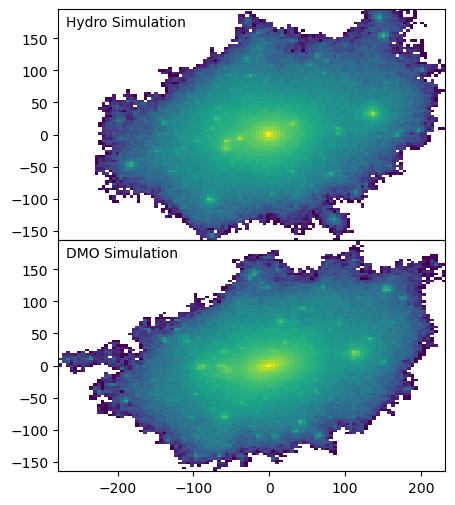

In [114]:
fig, axs = plt.subplots(2, 1, figsize=(5,6), sharex=True, sharey=True)

axs[0].hist2d(hydro_coordinates[:, 0], hydro_coordinates[:, 1], bins=100, norm='log', rasterized=True)
axs[1].hist2d(dmo_coordinates[:, 0], dmo_coordinates[:, 1], bins=100, norm='log', rasterized=True)

plt.text(0.02,0.925,'Hydro Simulation',transform=axs[0].transAxes)
plt.text(0.02,0.925,'DMO Simulation',transform=axs[1].transAxes)

plt.subplots_adjust(hspace=0.0)
plt.show()

Visually these halos are quite similar, though there are (of course) difference from the impact of baryons.